In [134]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
import re
from pylab import rcParams
from sklearn import linear_model
%matplotlib inline

In [135]:
rcParams['figure.figsize'] = 10,10
rcParams['axes.linewidth'] = 4.0
rcParams['savefig.dpi'] = 500
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [136]:
file="/home/cad234/Desktop/SRI_Binding2.txt"
df =pd.read_csv(file, header=None, sep='\t', engine='python')
df.columns = ["Compound", "Conf","DAT Uptake", "Error", "Emax"]

In [137]:
def rmse(pred, tar):
    return np.sqrt(((pred - tar) ** 2).mean())

def convertAffinity(x):
    return .593*np.log(x*1e-9)

In [138]:
df['Exp dG'] = df['DAT Uptake'].apply(convertAffinity)

df['Calc dG']=''
dG_list=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+"-pb.dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA TOTAL", line):
            dG_total = line.split()
            dG_list.append(dG_total[2])
df['Calc dG'] = dG_list
df['Calc dG'] = pd.to_numeric(df['Calc dG'])

In [139]:
X = sm.add_constant(df["Calc dG"])
Y = df["Exp dG"]

results = sm.OLS(Y - 1,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)
b = regr.intercept_
m = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                            OLS Regression Results                            
Dep. Variable:                 Exp dG   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     79.98
Date:                Tue, 20 Aug 2019   Prob (F-statistic):           1.07e-09
Time:                        15:23:41   Log-Likelihood:                -14.993
No. Observations:                  30   AIC:                             33.99
Df Residuals:                      28   BIC:                             36.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.0504      0.255    -55.120      0.0

/opt/Python-3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RMSD is: 16.59621523584221


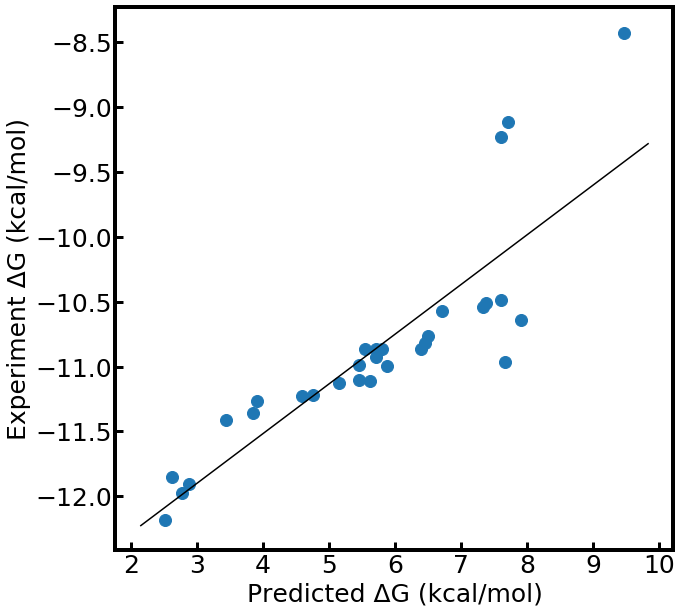

In [140]:
X=df["Calc dG"]
Y=df["Exp dG"]

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0')
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='k')
plt.ylabel("Experiment \u0394G (kcal/mol)", fontsize=25)
plt.xlabel('Predicted \u0394G (kcal/mol)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
# Save figure
#plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')
#plt.savefig("Correlation.pdf", transparent=True)
rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

In [141]:
def correctdG(Y):
    return m * Y + b # y=mx+b

RMSD is: 0.3988446725719613


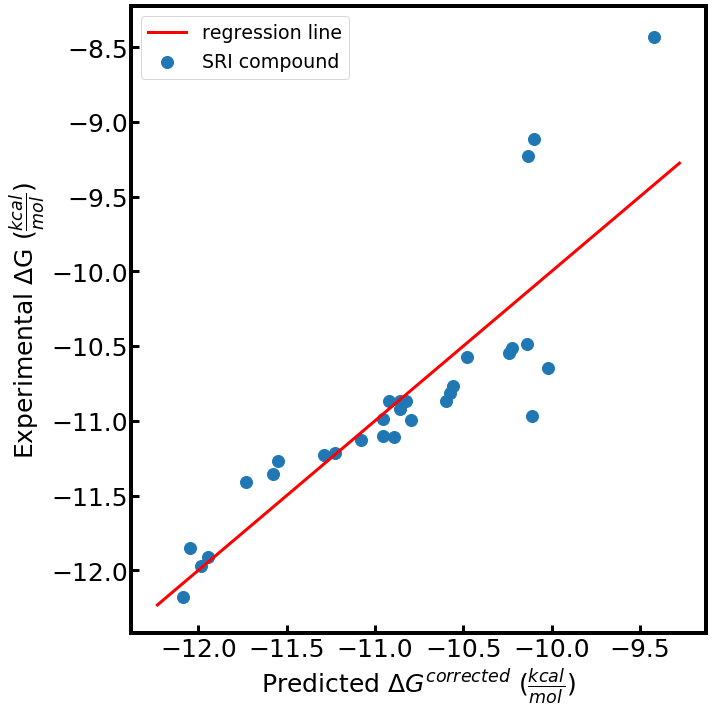

In [142]:
df['Correct dG'] = df["Calc dG"].apply(correctdG)
X=df["Correct dG"]
Y=df["Exp dG"]

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0', label="SRI compound")
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='red', label="regression line", linewidth="3")
plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12, -9, .5), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
plt.tight_layout()
# Save figure
plt.savefig("Correlation1.png", format='png', transparent=True)

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

In [143]:
def correctdG2(Y1, Y2):
    return m1 * Y1 + m2 * Y2 + b # y=mx+mx+b

In [144]:
dG_gas=[]
dG_solv=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+"-pb.dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA G gas", line):
            dG_gas_tmp = line.split()
            dG_gas.append(dG_gas_tmp[3])
        if re.match(r"DELTA G solv", line):
            dG_solv_tmp = line.split()
            dG_solv.append(dG_solv_tmp[3])
df['dG Gas']= dG_gas
df['dG Solvent']=dG_solv
df['dG Gas'] = pd.to_numeric(df['dG Gas'])
df['dG Solvent'] = pd.to_numeric(df['dG Solvent'])

In [145]:
X = df[['dG Gas','dG Solvent']]
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

regr = linear_model.LinearRegression()
regr.fit(X,Y)

b = regr.intercept_
m1 = regr.coef_[0]
m2 = regr.coef_[1]
print('Y-Intercept: ', regr.intercept_)
print('Slope: ', regr.coef_)

                                 OLS Regression Results                                
Dep. Variable:                 Exp dG   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              2389.
Date:                Tue, 20 Aug 2019   Prob (F-statistic):                    5.20e-32
Time:                        15:23:54   Log-Likelihood:                         -37.053
No. Observations:                  30   AIC:                                      78.11
Df Residuals:                      28   BIC:                                      80.91
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

RMSD is: 0.3699082367196048


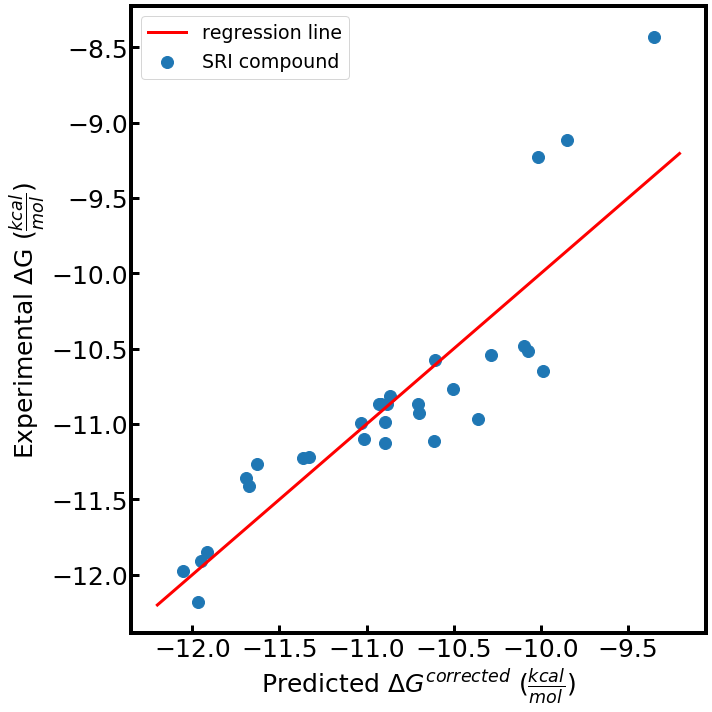

In [146]:
df['Correct dG2'] = df.apply(lambda x: correctdG2(x['dG Gas'], x['dG Solvent']), axis=1)
X=df['Correct dG2']
Y=df['Exp dG']

# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0', label="SRI compound")
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='red', label="regression line", linewidth="3")
plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12.0, -9.0, 0.5), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
plt.tight_layout()
# Save figure
plt.savefig("Correlation2.png", format='png', transparent=True)

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

# Testing code

In [17]:
export_csv = df.to_csv(r'/home/cad234/projects/SRI/ipn/exported_df_pb.csv')

In [ ]:
dG_gas=[]
dG_solv=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+".dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA G gas", line):
            dG_gas_tmp = line.split()
            dG_gas.append(dG_gas_tmp[3])
        if re.match(r"DELTA G solv", line):
            dG_solv_tmp = line.split()
            dG_solv.append(dG_solv_tmp[3])
df['dG Gas']= dG_gas
df['dG Solvent']=dG_solv

In [ ]:
df['test']=''
dG_list=[]
for k in range(30):
    i, j = df['Conf'][k].split('-',2)
    tmp = df['Compound'][k]
    cmpd = str(tmp)
    file="/home/cad234/projects/SRI/"+cmpd+"/dock_dat-SRI"+cmpd+"/SRI-cmpds/vina-"+i+"/minimization/mode-"+j+"/pbsa/Results-"+cmpd+"-"+i+"-"+j+".dat"
    readFile = open(file, "r")
    for line in readFile:
        line = line.strip() # strip end-on-line
        if re.match(r"DELTA TOTAL", line):
            dG_total = line.split()
            #print(dG_total[2])
            dG_list.append(dG_total[2])
            df['test'] = dG_List
        

In [ ]:
readFile = open(file, "r")
for line in readFile:
    line = line.strip() # strip end-on-line
    if re.match(r"DELTA G gas", line):
        dG_gas = line.split('                ')
    if re.match(r"DELTA G solv", line):
        dG_solv = line.split('                ')

In [ ]:
print(dG_gas[1], dG_solv[1])

In [101]:
X = sm.add_constant(df["Calc dG"])
#X['const']=0
print(X)

    const  Calc dG
0     1.0   7.6115
1     1.0   7.7053
2     1.0   7.3747
3     1.0   5.7204
4     1.0   9.4730
5     1.0   7.9103
6     1.0   5.4633
7     1.0   5.7178
8     1.0   3.4421
9     1.0   7.3269
10    1.0   5.6258
11    1.0   5.1503
12    1.0   6.4995
13    1.0   5.5514
14    1.0   2.6223
15    1.0   5.8032
16    1.0   6.7166
17    1.0   7.6704
18    1.0   6.4620
19    1.0   4.5967
20    1.0   3.8491
21    1.0   3.9179
22    1.0   4.7630
23    1.0   5.8875
24    1.0   7.5994
25    1.0   5.4638
26    1.0   2.5132
27    1.0   6.3984
28    1.0   2.8836
29    1.0   2.7792


In [147]:
X = sm.add_constant(df["Calc dG"])
X['const']=0
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())
print(results.params)

                                 OLS Regression Results                                
Dep. Variable:                 Exp dG   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              200.0
Date:                Tue, 20 Aug 2019   Prob (F-statistic):                    1.52e-14
Time:                        15:24:32   Log-Likelihood:                         -83.240
No. Observations:                  30   AIC:                                      168.5
Df Residuals:                      29   BIC:                                      169.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/Python-3.7.1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/Python-3.7.1/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/Python-3.7.1/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.p

In [148]:
df

,Compound,Conf,DAT Uptake,Error,Emax,Exp dG,Calc dG,Correct dG,dG Gas,dG Solvent,Correct dG2
0,29070,13-2,174.0,58.0,66,-9.229577,7.6115,-10.133754,-47.7045,55.3160,-10.018408
1,29072,18-4,212.0,49.0,71,-9.112441,7.7053,-10.097811,-43.4575,51.1628,-9.851320
2,29153,16-1,20.0,1.0,73,-10.512427,7.3747,-10.224492,-47.0304,54.4051,-10.072690
3,29155,15-4,10.0,1.0,74,-10.923464,5.7204,-10.858392,-49.9383,55.6587,-10.697579
4,29212,6-3,672.0,204.0,67,-8.428313,9.4730,-9.420458,-45.5554,55.0284,-9.351471
5,29213,3-1,16.0,4.0,81,-10.644752,7.9103,-10.019259,-49.6741,57.5844,-9.986003
6,29338,16-2,9.0,1.5,71,-10.985942,5.4633,-10.956908,-53.5346,58.9979,-10.896107
7,29554,3-5,11.0,1.0,71,-10.866945,5.7178,-10.859388,-50.1345,55.8523,-10.704741
8,29577,19-2,4.4,0.8,70,-11.410305,3.4421,-11.731399,-57.5175,60.9596,-11.673458
9,29776,19-1,19.0,4.0,69,-10.542844,7.3269,-10.242808,-53.2494,60.5763,-10.288610


In [152]:
X = df[['dG Gas','dG Solvent']]
X['const']=0
Y = df["Exp dG"]

results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())
print(results.params)

                                 OLS Regression Results                                
Dep. Variable:                 Exp dG   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              2389.
Date:                Tue, 20 Aug 2019   Prob (F-statistic):                    5.20e-32
Time:                        15:28:51   Log-Likelihood:                         -37.053
No. Observations:                  30   AIC:                                      78.11
Df Residuals:                      28   BIC:                                      80.91
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/Python-3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/Python-3.7.1/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/Python-3.7.1/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/Python-3.7.1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encounter

In [153]:
def correctdG2(Y1, Y2):
    return 0.114580 * Y1 + -0.074495 * Y2 # y=mx+mx+b

In [154]:
df['test dG2'] = df.apply(lambda x: correctdG2(x['dG Gas'], x['dG Solvent']), axis=1)
X=df['test dG2']
Y=df['Exp dG']

RMSD is: 0.8320810672354663


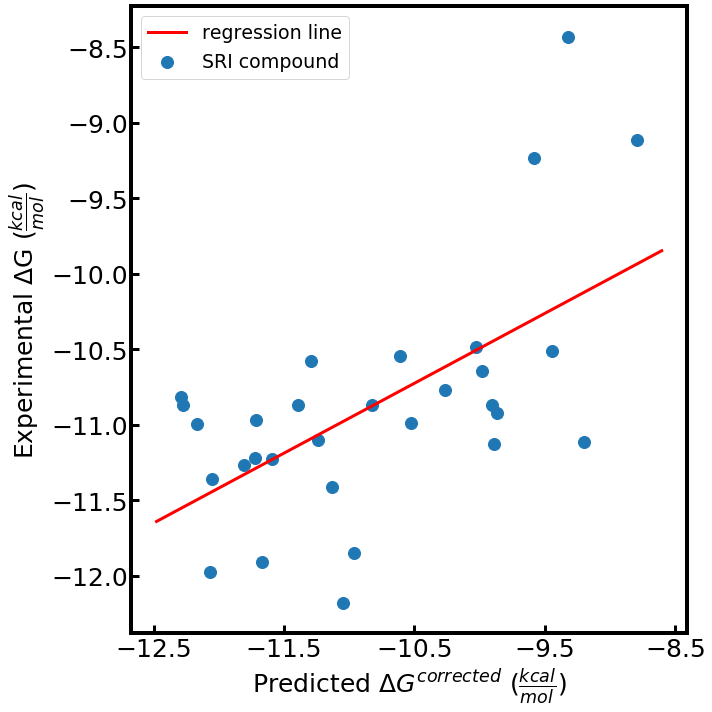

In [168]:
# Scatter plot
plt.scatter(X, Y, s=12**2, c='C0', label="SRI compound")
# Add correlation line
axes = plt.gca()
m, b = np.polyfit(X, Y, 1)
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-',color='red', label="regression line", linewidth="3")
plt.xlabel(r'Predicted $\Delta G^{corrected} \ (\frac{kcal}{mol})$', fontsize=25)
plt.ylabel(r'Experimental $\Delta$G $(\frac{kcal}{mol})$', fontsize=25)
plt.xticks(np.arange(-12.5, -8.0, 1), fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(which='both',direction='in',length=8, width=3,)
plt.legend(fontsize=19,handlelength=2,loc="best")
plt.tight_layout()
# Save figure
#plt.savefig("Correlation2.png", format='png', transparent=True)

rmse_val = rmse(X, Y)
print("RMSD is: " + str(rmse_val))

In [158]:
results = sm.OLS(Y,X.astype(float)).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 Exp dG   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              4948.
Date:                Tue, 20 Aug 2019   Prob (F-statistic):                    5.84e-34
Time:                        15:32:51   Log-Likelihood:                         -37.053
No. Observations:                  30   AIC:                                      76.11
Df Residuals:                      29   BIC:                                      77.51
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------